In [1]:
from psana import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

import sys
import os
import datetime

from scipy import ndimage
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

start_time = datetime.datetime.now()

In [2]:
bg_ds = DataSource('exp=meclt9417:run=409')
data_ds = DataSource('exp=meclt9417:run=410')
tt_det = Detector('opal7_Time_Tool')

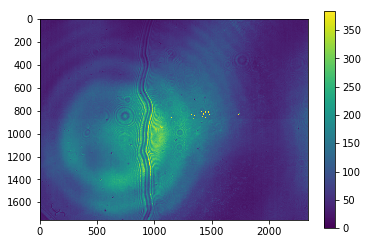

In [3]:
# Get average of background run
tt_bg = 0
for nevt, evt in enumerate(bg_ds.events()):
    img = tt_det.image(evt)
    tt_bg += img
bg_avg = tt_bg / (nevt+1)

# Plot background average
plt.imshow(bg_avg, clim=(0, 4*np.mean(bg_avg)))
plt.colorbar()
plt.show()

In [4]:
def errfunc(x, a, b, c, d):
    """
    Eric, where does this error function come from? None of the stuff I tried
    works as well for this data
    """
    return d + (a - d) / (1. + (x / c)**b)
def errfunc1(x, a, b, c):
    return a * erf( ( x - b ) / (c * np.sqrt(2) ) )
def errfunc2(x, a, b, c):
    return a * (1 + erf( ( x- b ) / c ) ) + d

In [5]:
def gaussian(x, x0, sigma, a):
    return a*np.exp(-(x-x0)**2/(2.*sigma**2))

In [6]:
# Get first 10 events or event n
def get_data(nevt=None):
    """
    Is this useful? How is this code used - is it executed for a whole run?
    Have option for whole run, one event, range of events
    """
    images = []
    if nevt != None:
        for idx, evt in enumerate(data_ds.events()):
            if idx == nevt:
                img = tt_det.image(evt)
                images.append(img)
    else:
        for idx, evt in enumerate(data_ds.events()):
            if idx == 10: break
            img = tt_det.image(evt)
            images.append(img)
    images = np.asarray(images)
    return images

In [7]:
# Subtract background, rotate, crop data images
def reduce_data(images, rot=None, crop=None):
    reduced_images = []
    for img in images:
        # Remove zeros
        img = np.where(img>0, img, 1)
        # Do background subtraction
        """
        Eric: In your code you do img = bg_avg - img, does that make more sense?
        It puts the edges at different positions.
        """
        #img = img - bg_avg
        img = bg_avg - img
        # Remove inf or NaN
        img[~np.isfinite(img)] = 0
        # Do rotation
        """
        Is this experiment dependent? Is there a way to extract this rotation angle
        from the image so it is not a hand entered parameter?
        The rotation of the camera is a function of the timetool camera. this is hardcoded
        """
        img = ndimage.rotate(img, -3.5, reshape=False)
        # Crop image
        """
        Same with crop to ROI, is the crop needed before doing lineout and fit? test
        """
        img = img[550:1300, 1000:1300]
        #img = img[400:1000, 800:1440]
        
        reduced_images.append(img)
        
        # Plot rotated, cropped, bgd subtracted image
        plt.imshow(img, clim=(0, 2*np.mean(bg_avg)))
        plt.colorbar()
        plt.show()
        # Plot lineout of background subtracted image
        lineout = img.sum(axis=1)
        plt.plot(lineout)
        plt.show()
    reduced_images = np.asarray(reduced_images)
    return reduced_images

In [8]:
# Plot lineout and find fit
def fit_edges(reduced_images):
    """
    This edge fit is not super reliable, for some images it picks the wrong edge
    Options:
    1. Explore other fit functions
    2. Canny edge
    3. Convolve with a matched filter
    """
    edges = np.array([])
    for img in reduced_images:
        lineout = img.sum(axis=1)
        # Execute the fit
        xdat = np.arange(len(lineout))
        popt, pcov = curve_fit(errfunc, xdat, lineout)
        edges = np.append(edges, popt[2])
        plt.plot(xdat, errfunc(xdat, popt[0], popt[1], popt[2], popt[3]))
        plt.plot(lineout)
        plt.axvline(x = popt[2])
        plt.show()
    return edges

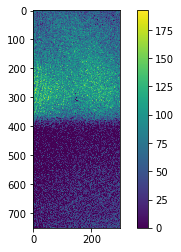

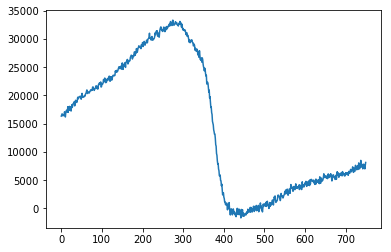

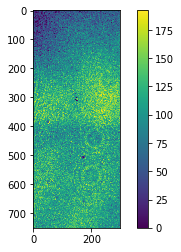

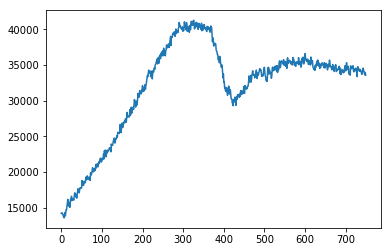

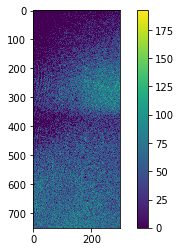

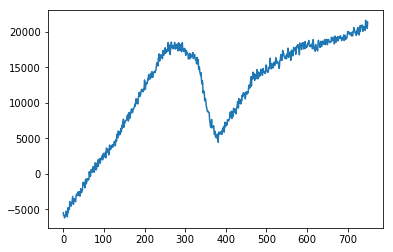

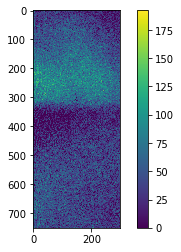

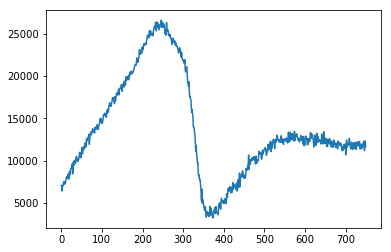

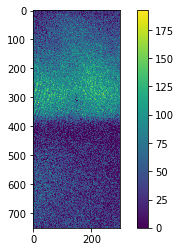

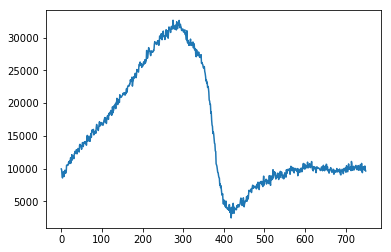

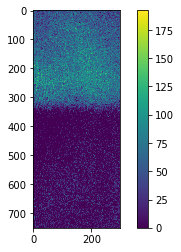

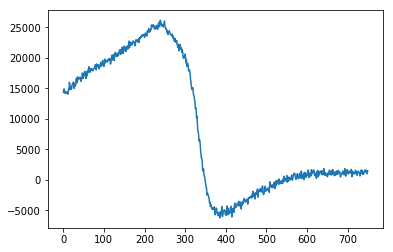

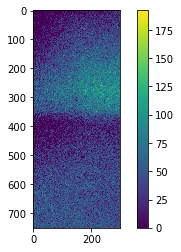

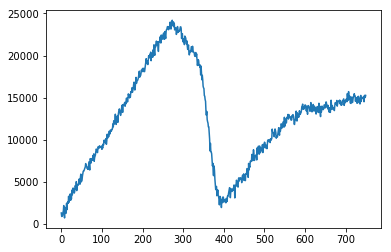

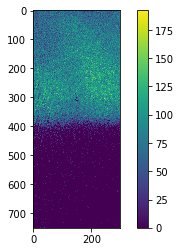

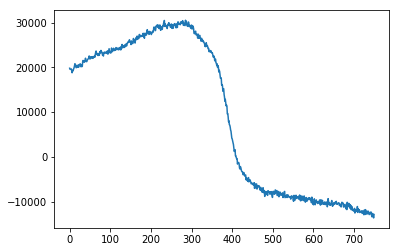

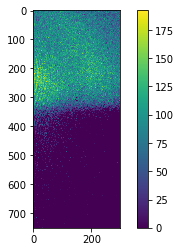

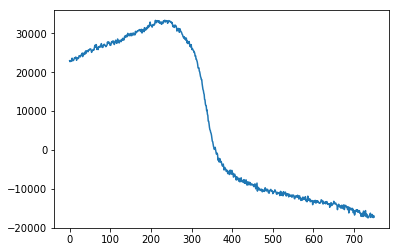

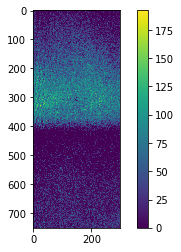

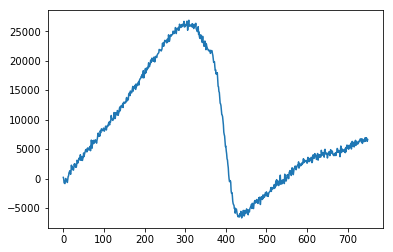

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in power
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in power
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


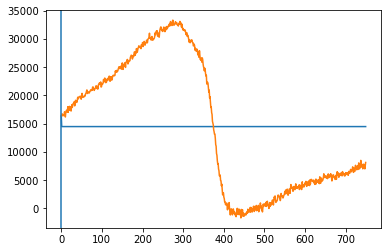

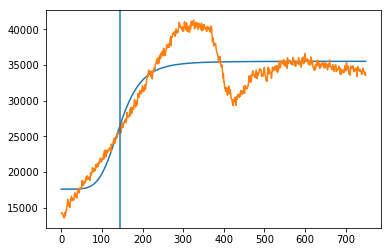

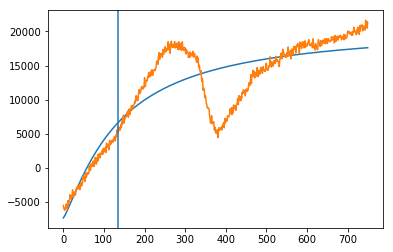

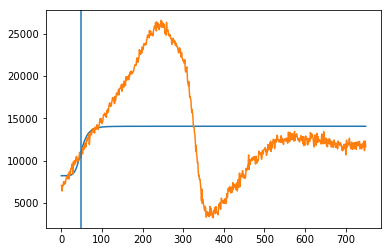

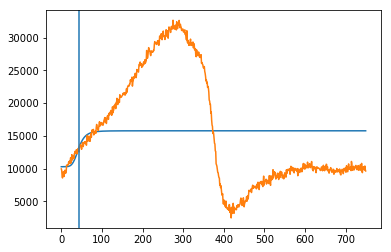

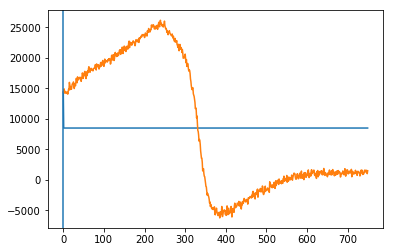

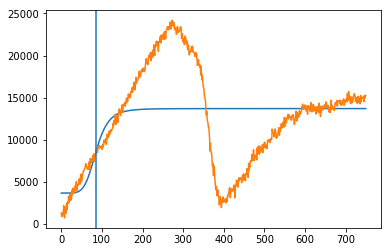

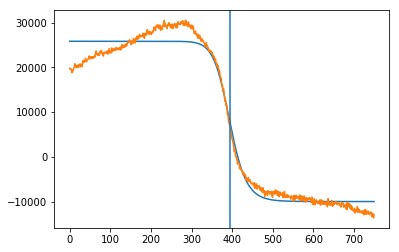

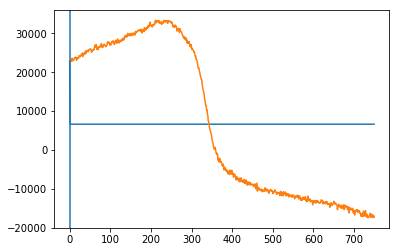

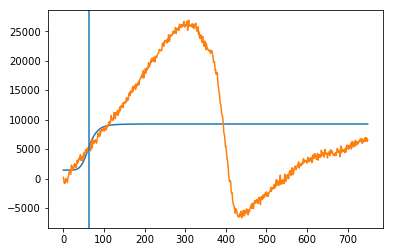

--- 0:00:41.613904 seconds needed to execute ---


In [9]:
images = get_data()
reduced_images = reduce_data(images)
edges = fit_edges(reduced_images)
# display time needed to execute the program
print("--- {} seconds needed to execute ---".format(datetime.datetime.now() - start_time))

(91.46766018549191, 112.40329860684608)


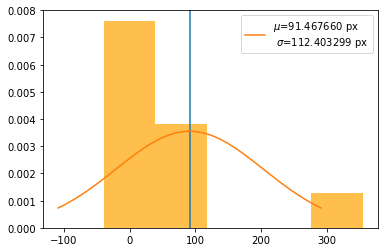

--- 0:00:42.047652 seconds needed to execute ---


'\nHow do we get a jitter in ps from pixel positions?\n'

In [10]:
# normalise to get the gaussian properly fitting with the sum under the guassian = 1
n, bins, patches = plt.hist(edges, bins='auto', density=True, align='left', facecolor='orange', alpha=0.7)
xi = np.linspace(np.mean(edges)-200, np.mean(edges)+200, 200)

# lets try the normal distribution first
mean, std = stats.norm.fit(edges) # get mean and standard deviation
print(mean, std)
pdf_g = stats.norm.pdf(xi, mean, std) # now get theoretical values in our interval
plt.axvline(x = mean)
plt.plot(xi, pdf_g, label = '$\mu$={:2f} px\n $\sigma$={:2f} px'.format(mean, std)) # plot it
plt.legend()

plt.show()

# display time needed to execute the program
print("--- {} seconds needed to execute ---".format(datetime.datetime.now() - start_time))

"""
How do we get a jitter in ps from pixel positions?
once you have edges: take several runs at different time delays
The jitter introduces the center of the delay - t0
slit size of 400um ~ -0.5ps
x.fs_timing.mv_rel --> change timing on the vitara by a known amount
Compare this known value to the centroid that you extract - at one time delay
Do +200ps to the point where you cross the centroid
"""

In [11]:
tt_pos = Detector('MEC:TIMETOOL:FLTPOS')

for nevt, evt in enumerate(data_ds.events()):
    if nevt == 10: break
    print tt_pos()

1394.75990466
1396.21268996
1721.84541753
1395.30428656
1395.15675002
1393.85728754
1395.07089097
880.442570818
1395.60008672
1394.98915601


In [12]:
edges+1000

array([1000.0063707 , 1144.3714552 , 1135.55787605, 1049.19541972,
       1042.51861067, 1000.02152886, 1085.89970804, 1393.94639482,
       1000.00272414, 1063.15651366])